# TALEA - Bologna Digital Twin: Multi-Modal Mobility Simulation
## Heat Stress Impact Analysis on Urban Mobility

**Author:** Juraj Sýkora  <br>
**Organization:** Alma Mater Studiorum - Università di Bologna, European Urban Initiative – Innovative Actions (EUI-IA) <br>
**Platform:** [TALEA platform](https://github.com/TALEA-platform) <br>
**GitHub Repository:** [https://github.com/sykorajuraj/TALEA_Digital_Twin](https://github.com/sykorajuraj/TALEA_Digital_Twin) <br>
**Date:** December 2025 - January 2026 <br>

---

## Overview

This notebook demonstrates the complete pipeline for simulating multi-modal urban mobility under heat stress scenarios in Bologna, Italy. It integrates:

- **6 Mobility Datasets**: Bicycle counters, pedestrian flows, street network, traffic monitors, pedestrian zones (ZTL), points of interest
- **3 Weather Datasets**: Temperature, precipitation, air quality
- **Heat Stress Analysis**: Heat indices, vulnerability mapping, heat islands
- **Agent-Based Simulation**: Pedestrians, cyclists, and vehicles with behavioral models

## Pipeline Architecture

```
Datasets Loading → Preprocessing → Heat Stress/Heat Stress/Patterns Analysis → Custom Simulation → Analysis & Visualization
```

## 1. Setup and Imports

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✓ Core libraries imported")

✓ Core libraries imported


In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  # notebooks → project
sys.path.insert(0, str(PROJECT_ROOT))

# TALEA modules - Data Loading & Preprocessing
from src.data_loader import DataLoader, load_dataset, load_mobility_data, load_weather_data
from src.data_preprocessor import TALEAConfig, TALEADataPreprocessor, DataIntegrator
from src.data_preprocessing.mobility_preprocessor import MobilityPreprocessor, ProcessingConfig
from src.data_preprocessing.weather_preprocessor import WeatherPreprocessor, WeatherConfig
from src.data_preprocessing.geospatial_preprocessor import GeospatialPreprocessor
from src.data_preprocessing.integrator import DataIntegrator

print("✓ Data processing modules imported")

✓ Data processing modules imported


In [3]:
# TALEA modules - Heat Stress & Impact Analysis
from src.analysis.heat_stress.heat_stress_calculator import HeatStressCalculator, HeatStressThresholds
from src.analysis.heat_stress.vulnerability_mapper import VulnerabilityMapper
from src.analysis.heat_impact.mobility_impact_analyzer import MobilityImpactAnalyzer
from src.analysis.heat_impact.route_impact_analyzer import RouteImpactAnalyzer
from src.analysis.patterns.spatial_patterns_correlation_analyzer import SpatialPatternAnalyzer, CorrelationAnalyzer
from src.analysis.patterns.temporal_patterns import TemporalPatternAnalyzer

print("✓ Analysis modules imported")

✓ Analysis modules imported


In [4]:
# TALEA modules - Simulation Engine & API
from src.simulation.engine.simulation_engine import SimulationEngine, SimulationConfig, ScenarioManager
from src.simulation.models.environment import UrbanEnvironment, WeatherConditions
from src.simulation.models.agent import MobilityAgent
from src.simulation.api.simulation_api import SimulationAPI, SimulationAPIConfig

print("✓ Simulation modules imported")

✓ Simulation modules imported


## 2. Data Loading

Load all 9 datasets from the Bologna dataset collection. <br>Source: [https://opendata.comune.bologna.it/](https://opendata.comune.bologna.it/)

In [5]:
# Initialize data loader
data_dir = Path('../dataset') # Current path to datasets '/dataset'
loader = DataLoader(data_dir)

# List available datasets
print("Available datasets:")
for name, info in loader.get_dataset_info().items():
    print(f"  - {name:15s} ({info.type:12s}): {info.description}")

Available datasets:
  - bicycle         (mobility    ): Bicycle counter data
  - pedestrian      (mobility    ): Pedestrian flow data
  - traffic         (mobility    ): Traffic monitor data
  - street          (geospatial  ): Street network
  - poi             (geospatial  ): Points of Interest
  - ztl             (geospatial  ): Pedestrian zones
  - temperature     (weather     ): Temperature data
  - precipitation   (weather     ): Precipitation data
  - air_quality     (weather     ): Air quality monitoring


### 2.1 Load Mobility Data

In [6]:
# Load mobility datasets
mobility_data = loader.load_by_type('mobility', skip_missing=True)

# Access individual datasets
bicycle_df = mobility_data.get('bicycle')
pedestrian_df = mobility_data.get('pedestrian')
traffic_df = mobility_data.get('traffic')

print(f"\nMobility Data Loaded:")
for name, df in mobility_data.items():
    if df is not None:
        print(f"  {name:12s}: {df.shape[0]:,} rows × {df.shape[1]} cols")

LOADING DATASETS
Data directory: /mnt/c/UniBO/AII/TALEA/TALEA_Digital_Twin/dataset
Working directory: /mnt/c/UniBO/AII/TALEA/TALEA_Digital_Twin/notebooks

✓ Loaded bicycle: 389,078 rows × 6 columns
✓ Loaded pedestrian: 43,740 rows × 4 columns
✓ Loaded traffic: 6,944 rows × 59 columns

✓ Loaded 3/3 datasets


Mobility Data Loaded:
  bicycle     : 389,078 rows × 6 cols
  pedestrian  : 43,740 rows × 4 cols
  traffic     : 6,944 rows × 59 cols


### 2.2 Load Geospatial Data

In [7]:
# Load geospatial datasets
geospatial_data = loader.load_by_type('geospatial', skip_missing=True)

street_df = geospatial_data.get('street')
poi_df = geospatial_data.get('poi')
ztl_df = geospatial_data.get('ztl')

print(f"\nGeospatial Data Loaded:")
for name, df in geospatial_data.items():
    if df is not None:
        print(f"  {name:12s}: {df.shape[0]:,} rows × {df.shape[1]} cols")

LOADING DATASETS
Data directory: /mnt/c/UniBO/AII/TALEA/TALEA_Digital_Twin/dataset
Working directory: /mnt/c/UniBO/AII/TALEA/TALEA_Digital_Twin/notebooks

✓ Loaded street: 8,014 rows × 22 columns
✓ Loaded poi: 761 rows × 28 columns
✓ Loaded ztl: 62 rows × 23 columns

✓ Loaded 3/3 datasets


Geospatial Data Loaded:
  street      : 8,014 rows × 22 cols
  poi         : 761 rows × 28 cols
  ztl         : 62 rows × 23 cols


### 2.3 Load Weather Data

In [8]:
# Load weather datasets
weather_data = loader.load_by_type('weather', skip_missing=True)

temperature_df = weather_data.get('temperature')
precipitation_df = weather_data.get('precipitation')
air_quality_df = weather_data.get('air_quality')

print(f"\nWeather Data Loaded:")
for name, df in weather_data.items():
    if df is not None:
        print(f"  {name:12s}: {df.shape[0]:,} rows × {df.shape[1]} cols")

LOADING DATASETS
Data directory: /mnt/c/UniBO/AII/TALEA/TALEA_Digital_Twin/dataset
Working directory: /mnt/c/UniBO/AII/TALEA/TALEA_Digital_Twin/notebooks

✓ Loaded temperature: 9,145 rows × 5 columns
✓ Loaded precipitation: 9,145 rows × 3 columns
✓ Loaded air_quality: 75,890 rows × 5 columns

✓ Loaded 3/3 datasets


Weather Data Loaded:
  temperature : 9,145 rows × 5 cols
  precipitation: 9,145 rows × 3 cols
  air_quality : 75,890 rows × 5 cols


## 3. Data Preprocessing

Clean, standardize, and prepare data for analysis and simulation.

### 3.1 Mobility Data Preprocessing

In [9]:
# Initialize mobility preprocessor
mobility_prep = MobilityPreprocessor()

# Process bicycle data
if bicycle_df is not None:
    print("=" * 70)
    print("PROCESSING BICYCLE DATA")
    print("=" * 70)
    
    bicycle_clean = mobility_prep.preprocess_bicycle_data(
        bicycle_df,
        datetime_col='Data',  # Column 'Data' in preprocessed dataset
        count_col='N° Passaggi'
    )
    
    print(f"\n✓ Processed: {len(bicycle_clean):,} bicycle observations")
    print(f"  Date range: {bicycle_clean['datetime'].min()} to {bicycle_clean['datetime'].max()}")
    print(f"  Total passages: {bicycle_clean['Totale'].sum():,.0f}")

PROCESSING BICYCLE DATA

PREPROCESSING BICYCLE DATA

Step 1/5: Cleaning data...
  ✓ Cleaned: 388,976 records

Step 2/5: Aggregating to hourly frequency...
  ✓ Aggregated: 60,840 hourly records

Step 3/5: Handling missing values...
  ✓ Missing values handled

Step 4/5: Adding derived features...
  ✓ Added features (columns: 17)

Step 5/5: Skipping normalization

✓ BICYCLE DATA PREPROCESSING COMPLETE


✓ Processed: 60,840 bicycle observations
  Date range: 2018-12-31 23:00:00 to 2025-12-09 22:00:00
  Total passages: 19,148,506


In [10]:
# Initialize mobility preprocessor
mobility_prep = MobilityPreprocessor()

# Process bicycle data
if bicycle_df is not None:
    print("=" * 70)
    print("PROCESSING BICYCLE DATA")
    print("=" * 70)
    
    bicycle_clean = mobility_prep.preprocess_bicycle_data(
        bicycle_df,
        datetime_col='Data',  # Column 'Data' in preprocessed dataset
        count_col='N° Passaggi'
    )
    
    print(f"\n✓ Processed: {len(bicycle_clean):,} bicycle observations")
    print(f"  Date range: {bicycle_clean['datetime'].min()} to {bicycle_clean['datetime'].max()}")
    print(f"  Total passages: {bicycle_clean['Totale'].sum():,.0f}")

PROCESSING BICYCLE DATA

PREPROCESSING BICYCLE DATA

Step 1/5: Cleaning data...
  ✓ Cleaned: 388,976 records

Step 2/5: Aggregating to hourly frequency...
  ✓ Aggregated: 60,840 hourly records

Step 3/5: Handling missing values...
  ✓ Missing values handled

Step 4/5: Adding derived features...
  ✓ Added features (columns: 17)

Step 5/5: Skipping normalization

✓ BICYCLE DATA PREPROCESSING COMPLETE


✓ Processed: 60,840 bicycle observations
  Date range: 2018-12-31 23:00:00 to 2025-12-09 22:00:00
  Total passages: 19,148,506


In [11]:
# Process pedestrian data
if pedestrian_df is not None:
    print("=" * 70)
    print("PROCESSING PEDESTRIAN DATA")
    print("=" * 70)
    
    pedestrian_clean = mobility_prep.preprocess_pedestrian_data(
        pedestrian_df,
        datetime_col='Data',
        count_col='Passaggi'
    )
    
    print(f"\n✓ Processed: {len(pedestrian_clean):,} pedestrian observations")
    print(f"  Date range: {pedestrian_clean['datetime'].min()} to {pedestrian_clean['datetime'].max()}")
    print(f"  Total passages: {pedestrian_clean['Numero di visitatori'].sum():,.0f}")

PROCESSING PEDESTRIAN DATA

PREPROCESSING PEDESTRIAN DATA

Step 1/4: Cleaning data...
  ✓ Cleaned: 43,740 records

Step 2/4: Adding temporal features...
  ✓ Added features (columns: 10)

Step 3/4: Skipping zone aggregation

Step 4/4: Skipping normalization (column not found)

✓ PEDESTRIAN DATA PREPROCESSING COMPLETE


✓ Processed: 43,740 pedestrian observations
  Date range: 2019-07-01 00:00:00 to 2021-03-31 00:00:00
  Total passages: 79,181,214


In [12]:
# Process traffic data
if traffic_df is not None:
    print("=" * 70)
    print("PROCESSING TRAFFIC DATA")
    print("=" * 70)
    
    traffic_clean = mobility_prep.preprocess_traffic_data(
        traffic_df,
        datetime_col='data',
    )
    
    print(f"\n✓ Processed: {len(traffic_clean):,} traffic observations")
    print(f"  Date range: {traffic_clean['datetime'].min()} to {traffic_clean['datetime'].max()}")

PROCESSING TRAFFIC DATA

PREPROCESSING TRAFFIC DATA

Step 1/4: Cleaning and reshaping data...
  ✓ Cleaned: 333,312 records

Step 2/4: Capping outliers...
  ⚠ Capped 334 outlier values at 1030

Step 3/4: Categorizing traffic levels...
  ✓ Traffic categories added

Step 4/4: Computing congestion index...
  ✓ Congestion index computed

✓ TRAFFIC DATA PREPROCESSING COMPLETE


✓ Processed: 333,312 traffic observations
  Date range: 2019-01-08 00:00:00 to 2025-11-26 23:30:00


### 3.2 Weather Data Preprocessing

Process and integrate weather datasets including temperature, precipitation, and air quality data.

In [13]:
# Configure thresholds for Bologna's climate
weather_config = WeatherConfig(
    HOT_DAY_TEMP=25.0,           # Temperature threshold for hot days (°C)
    VERY_HOT_DAY_TEMP=30.0,      # Very hot day threshold (°C)
    EXTREME_HEAT_TEMP=35.0,      # Extreme heat threshold (°C)
    RAINY_DAY_MM=0.1,            # Minimum precipitation for rainy day (mm)
    HEAVY_RAIN_MM=10.0,          # Heavy rain threshold (mm)
    PRECIPITATION_ROLLING_DAYS=7, # Rolling window for precipitation
    TEMP_ROLLING_DAYS=3          # Rolling window for temperature
)

# Initialize Weather Preprocessor
print("\n" + "="*70)
print("WEATHER DATA PREPROCESSING")
print("="*70 + "\n")

weather_preprocessor = WeatherPreprocessor()

# Merge all weather datasets
weather_merged = weather_preprocessor.merge_weather_datasets(
    temp_df=temperature_df,
    precip_df=precipitation_df,
    aq_df=air_quality_df
)

print(f"✓ Merged weather data: {len(weather_merged):,} records")
print(f"  Temperature range: {weather_merged['temperature'].min():.1f}°C to {weather_merged['temperature'].max():.1f}°C")


WEATHER DATA PREPROCESSING

✓ Merged weather data: 17,795 records
✓ Merged weather data: 17,795 records
  Temperature range: -7.6°C to 33.2°C


### 3.3 Geospatial Data Preprocessing

In [14]:
print("="*70)
print("CONVERTING BOLOGNA STREET DATA TO GEODATAFRAME")
print("="*70 + "\n")

import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
import pandas as pd
import json

print(f"Input: {len(street_df):,} rows")
print(f"✓ Found 'Geo Shape' column")

# Parse Geo Shape column - it contains lowercase GeoJSON
geometries = []
parse_errors = 0
error_samples = []

print("\nParsing GeoJSON geometries...")
for idx, geo_value in enumerate(street_df['Geo Shape']):
    try:
        if pd.isna(geo_value):
            geometries.append(None)
            continue
        
        # Parse as JSON (lowercase keys: "coordinates", "type")
        geo_dict = json.loads(geo_value)
        
        geom_type = geo_dict.get('type')
        coords = geo_dict.get('coordinates')
        
        if geom_type == 'LineString' and coords:
            geom = LineString(coords)
            geometries.append(geom)
        elif geom_type == 'MultiLineString' and coords:
            geom = MultiLineString(coords)
            geometries.append(geom)
        else:
            geometries.append(None)
            parse_errors += 1
            if len(error_samples) < 3:
                error_samples.append(f"Row {idx}: Unknown type '{geom_type}'")
            
    except json.JSONDecodeError as e:
        geometries.append(None)
        parse_errors += 1
        if len(error_samples) < 3:
            error_samples.append(f"Row {idx}: JSON error - {str(e)[:50]}")
    except Exception as e:
        geometries.append(None)
        parse_errors += 1
        if len(error_samples) < 3:
            error_samples.append(f"Row {idx}: {str(e)[:50]}")

# Show any errors
if error_samples:
    print("  Sample errors:")
    for err in error_samples:
        print(f"    {err}")

# Create GeoDataFrame
street_df['geometry'] = geometries
street_gdf = gpd.GeoDataFrame(street_df, geometry='geometry', crs='EPSG:4326')

valid_count = street_gdf.geometry.notna().sum()
print(f"\n✓ Successfully parsed {valid_count:,} / {len(street_df):,} geometries")

if parse_errors > 0:
    print(f"  ⚠ {parse_errors} parse errors (will be removed)")

# Remove rows with null geometries
street_gdf = street_gdf[street_gdf.geometry.notna()].copy()

if len(street_gdf) == 0:
    print("\n❌ ERROR: All geometries failed to parse!")
    print("Please check the error samples above.")
    raise ValueError("No valid geometries parsed")

print(f"✓ After removing nulls: {len(street_gdf):,} rows")

# Check geometry types
geom_types = street_gdf.geometry.type.value_counts()
print(f"\nGeometry types:")
for gtype, count in geom_types.items():
    print(f"  - {gtype}: {count:,}")

# Filter to LineString/MultiLineString
valid_types = street_gdf.geometry.type.isin(['LineString', 'MultiLineString'])
street_gdf = street_gdf[valid_types].copy()

if len(street_gdf) == 0:
    print("\n❌ ERROR: No LineString geometries after filtering!")
    raise ValueError("No LineString geometries")

# Fix invalid geometries
invalid_mask = ~street_gdf.geometry.is_valid
if invalid_mask.sum() > 0:
    print(f"  Fixing {invalid_mask.sum()} invalid geometries...")
    street_gdf.loc[invalid_mask, 'geometry'] = street_gdf.loc[invalid_mask, 'geometry'].buffer(0)

print(f"\nFinal result: {len(street_gdf):,} valid LineString segments")

# Update street_df
street_df = street_gdf.copy()

# Show sample
sample_geom = street_gdf.geometry.iloc[0]
print(f"\nSample geometry:")
print(f"  Type: {sample_geom.geom_type}")
print(f"  Points in line: {len(list(sample_geom.coords))}")
print(f"  First 3 coords: {list(sample_geom.coords)[:3]}")

print("\n" + "="*70)
print("CONVERSION COMPLETE")
print("="*70 + "\n")

CONVERTING BOLOGNA STREET DATA TO GEODATAFRAME

Input: 8,014 rows
✓ Found 'Geo Shape' column

Parsing GeoJSON geometries...

✓ Successfully parsed 8,014 / 8,014 geometries
✓ After removing nulls: 8,014 rows

Geometry types:
  - LineString: 8,014

Final result: 8,014 valid LineString segments

Sample geometry:
  Type: LineString
  Points in line: 20
  First 3 coords: [(11.38248969198932, 44.459281263141364), (11.382538682185759, 44.45931876289701), (11.38256639400456, 44.459369301420125)]

CONVERSION COMPLETE



In [15]:
print("="*70)
print("GEOSPATIAL DATA PREPROCESSING")
print("="*70 + "\n")

geo_preprocessor = GeospatialPreprocessor()

# Verify conversion worked
if not isinstance(street_df, gpd.GeoDataFrame):
    raise ValueError("Run conversion cell first! street_df is not a GeoDataFrame")

print("Processing street network...")
print(f"  Input: {len(street_df):,} segments")

# Manual cleaning (skip _ensure_geodataframe)
street_gdf = street_df.copy()

# Set/verify CRS
if street_gdf.crs is None:
    street_gdf = street_gdf.set_crs("EPSG:4326")

# Transform to projected CRS
gdf_projected = street_gdf.to_crs("EPSG:32632")

# Clean
initial = len(gdf_projected)
gdf_projected = gdf_projected[gdf_projected.geometry.notna()]
gdf_projected = gdf_projected[gdf_projected.geometry.is_valid]
gdf_projected = gdf_projected.drop_duplicates(subset='geometry')

removed = initial - len(gdf_projected)
if removed > 0:
    print(f"  Removed {removed} invalid/duplicate segments")

# Calculate length
if 'length_m' not in gdf_projected.columns:
    gdf_projected['length_m'] = gdf_projected.geometry.length

# Transform back
street_gdf = gdf_projected.to_crs("EPSG:4326")

print(f"✓ Cleaned: {len(street_gdf):,} segments")
print(f"  Total length: {street_gdf['length_m'].sum()/1000:.1f} km\n")

# Compute metrics
street_gdf = geo_preprocessor.compute_network_metrics(street_gdf)

# Process POI
poi_gdf = geo_preprocessor.process_poi(poi_df, category_column='poi_category')

# Create grid
minx, miny, maxx, maxy = street_gdf.total_bounds
grid_gdf = geo_preprocessor.create_spatial_grid(
    bounds=(minx, miny, maxx, maxy),
    resolution=0.025
)

print(f"✓ Grid: {len(grid_gdf):,} cells")

# Final check
assert len(street_gdf) > 0, "street_gdf is empty!"
print(f"Summary:")
print(f"  street_gdf: {len(street_gdf):,} segments ({street_gdf['length_m'].sum()/1000:.1f} km)")
print(f"  poi_gdf: {len(poi_gdf):,} points")
print(f"  grid_gdf: {len(grid_gdf):,} cells")

GEOSPATIAL DATA PREPROCESSING

Processing street network...
  Input: 8,014 segments
✓ Cleaned: 8,014 segments
  Total length: 1041.6 km

  ✓ Network metrics computed
  ✓ Processed POI: 708 points
  ✓ Created grid: 1,759,600 cells
    Resolution: ~3m × 3m
✓ Grid: 1,759,600 cells
Summary:
  street_gdf: 8,014 segments (1041.6 km)
  poi_gdf: 708 points
  grid_gdf: 1,759,600 cells


## 4. Heat Stress Analysis

Calculate heat indices, identify vulnerable populations, and map heat islands.

### 4.1 Calculate Heat Indices

In [16]:
# Heat Stress Calculation
print("="*70)
print("HEAT STRESS ANALYSIS")
print("="*70 + "\n")

heat_calc = HeatStressCalculator()

# Compute heat index
heat_stress_df = weather_merged.copy()
heat_stress_df['heat_index'] = heat_calc.compute_heat_index(
    temperature=heat_stress_df['temperature'],
    humidity=heat_stress_df.get('humidity', pd.Series(60, index=heat_stress_df.index))
)

# Classify heat stress levels
heat_stress_df['heat_index_level'] = heat_calc.classify_stress_levels(
    heat_stress_df['heat_index']
)

print(f"✓ Heat stress computed for {len(heat_stress_df):,} records")
print(f"  Danger days: {(heat_stress_df['heat_index_level'] == 'danger').sum()}")
print(f"  Extreme danger days: {(heat_stress_df['heat_index_level'] == 'extreme_danger').sum()}")

HEAT STRESS ANALYSIS

✓ Heat stress computed for 17,795 records
  Danger days: 1
  Extreme danger days: 0


### 4.2 Vulnerability Mapping

In [17]:
print("="*70)
print("VULNERABILITY MAPPING")
print("="*70 + "\n")

vuln_mapper = VulnerabilityMapper()

# Map vulnerable populations
poi_gdf = vuln_mapper.map_vulnerable_populations(poi_gdf)

# Compute exposure scores
grid_gdf = vuln_mapper.compute_exposure_scores(
    grid=grid_gdf,
    heat_stress_df=heat_stress_df,
    heat_index_col='heat_index'
)

# Identify heat islands
grid_gdf = vuln_mapper.identify_heat_islands(
    grid=grid_gdf,
    temperature_df=heat_stress_df,
    temperature_col='temperature',
    threshold_percentile=75.0,
)

# Compute vulnerability index
grid_gdf = vuln_mapper.compute_vulnerability_index(
    grid=grid_gdf,
    poi_gdf=poi_gdf
)

# Generate report
vulnerability_report = vuln_mapper.generate_vulnerability_report(
    grid=grid_gdf,
    poi_gdf=poi_gdf
)

print("\nVulnerability Summary:")
print(f"  Heat islands: {vulnerability_report['heat_islands']['count']}")
print(f"  Vulnerable POIs: {vulnerability_report['vulnerable_populations']['total_vulnerable_poi']}")
print(f"  Critical cells: {vulnerability_report['vulnerability']['critical_cells']}")

VULNERABILITY MAPPING

  ✓ Identified 0 vulnerable POIs
  ✓ Computed exposure scores for 1759600 grid cells
  ✓ Identified 1759600 heat island cells (>14.8°C)
  ✓ Computed vulnerability index

Vulnerability Summary:
  Heat islands: 1759600
  Vulnerable POIs: 0
  Critical cells: 0


## 5. Mobility Impact Analysis

Analyze how heat stress affects mobility patterns.

### 5.1 Mobility Response to Heat

In [18]:
print("="*70)
print("MOBILITY IMPACT ANALYSIS")
print("="*70 + "\n")

mobility_analyzer = MobilityImpactAnalyzer()

# Analyze bicycle-heat correlation
bicycle_impact = mobility_analyzer.analyze_bicycle_heat_correlation(
    bicycle_df=bicycle_df,
    weather_df=weather_merged,
    count_col='Totale',
    temp_col='temperature'
)

# Analyze pedestrian-heat correlation
pedestrian_impact = mobility_analyzer.analyze_pedestrian_heat_correlation(
    pedestrian_df=pedestrian_df,
    weather_df=weather_merged,
    count_col='Numero di visitatori',
    temp_col='temperature'
)

print(f"\nBicycle Impact: {bicycle_impact['pct_change']:+.1f}% in high heat")
print(f"Pedestrian Impact: {pedestrian_impact['pct_change']:+.1f}% in high heat")

MOBILITY IMPACT ANALYSIS

  ✓ Bicycle-heat correlation: r=0.068, p=0.0000
    Impact: -8.7% in high heat
  ✓ Pedestrian-heat correlation: r=0.066, p=0.0000
    Impact: +8.2% in high heat

Bicycle Impact: -8.7% in high heat
Pedestrian Impact: +8.2% in high heat


### 5.2 Route Impact Analysis

In [19]:
print("="*70)
print("ROUTE IMPACT ANALYSIS")
print("="*70 + "\n")

route_analyzer = RouteImpactAnalyzer()

# Compute heat exposure by route
street_gdf = route_analyzer.compute_heat_exposure_by_route(
    network=street_gdf,
    heat_grid=grid_gdf,
    heat_col='avg_temp'
)

# Identify cooling corridors
street_gdf = route_analyzer.identify_cooling_corridors(
    network=street_gdf,
    heat_threshold=None  # Uses bottom 25%
)

print(f"✓ Route heat exposure computed")
print(f"  Cooling corridors: {street_gdf['is_cooling_corridor'].sum()} segments")
print(f"  High exposure routes: {(street_gdf['exposure_level'] == 'high').sum()} segments")

ROUTE IMPACT ANALYSIS

  ✓ Computed heat exposure for 8014 route segments
  ✓ Identified 8014 cooling corridor segments (100.0%)
✓ Route heat exposure computed
  Cooling corridors: 8014 segments
  High exposure routes: 0 segments


### 5.3 Spatial and Temporal Pattern Analysis

In [20]:
# Spatial Patterns
print("="*70)
print("SPATIAL PATTERN ANALYSIS")
print("="*70 + "\n")

spatial_analyzer = SpatialPatternAnalyzer()

# WARNING: EXPECTING LARGE MEMORY FOR COMPUTE

# Compute spatial autocorrelation
# heat_autocorr = spatial_analyzer.compute_spatial_autocorrelation(
#     gdf=grid_gdf,
#     value_col='avg_temp'
# )

# Identify hotspots
# hotspots = spatial_analyzer.compute_hotspots(
#     gdf=grid_gdf,
#     value_col='avg_temp',
# )

print(f"✓ Spatial analysis complete")
#print(f"  Moran's I: {heat_autocorr['morans_i']:.3f}")
#print(f"  Hotspots: {(hotspots['cluster_type'] == 'hotspot').sum()}")

SPATIAL PATTERN ANALYSIS

✓ Spatial analysis complete


In [21]:
# Temporal Patterns
print("="*70)
print("TEMPORAL PATTERN ANALYSIS")
print("="*70 + "\n")

temporal_analyzer = TemporalPatternAnalyzer()

# Analyze daily patterns
daily_patterns = temporal_analyzer.detect_daily_patterns(
    df=heat_stress_df,
    groupby_cols=['hour'],
    value_col=['temperature', 'heat_index']
)

# Peak temperature hour
peak_hours = temporal_analyzer.identify_peak_hours(
    df=heat_stress_df,
    value_col=['temperature', 'heat_index'],
    n_peaks=16
)

print(f"✓ Temporal analysis complete")
print(f"  Peak temperature hour: {peak_hours['temperature']['peak_hours'][14]}")

TEMPORAL PATTERN ANALYSIS

  ✓ Detected daily patterns across 24 combinations
  ✓ Identified 16 peak hours for 2 columns
✓ Temporal analysis complete
  Peak temperature hour: 14


### 5.4 WET BULB TEMPERATURE EFFECT DETECTION

This detection is inspirated by the book **Nomad Century** by Gaia Vince.

Unlike simple air temperature, wet bulb temperature represents the **lowest temperature achievable through evaporative cooling**, making it essential for understanding heat stress on human health. When wet bulb temperatures exceed ~35°C, the human body cannot cool itself through sweating, even in perfect shade and with unlimited water.


WET BULB TEMPERATURE EFFECT ANALYSIS

Wet Bulb Globe Temperature (WBGT) Statistics:
  Mean:   11.7°C
  Median: 11.7°C
  Max:    28.8°C
  Min:    -9.1°C
  Std:    7.7°C

WBGT Risk Level Distribution:
  Low         :  6784 ( 38.1%)
  Moderate    :  1700 (  9.6%)
  High        :   659 (  3.7%)
  Very_high   :     2 (  0.0%)
  Extreme     :     0 (  0.0%)

WBGT vs Heat Index Comparison:
  Mean difference (WBGT - HI): -2.34°C
  Max difference:               1.60°C
  Min difference:               -11.26°C

Wet Bulb Effect Detection:
  High/Very High conditions (≥28°C): 2 (0.0%)
  Extreme conditions (≥32°C):        0 (0.0%)

⚠️  CRITICAL: 257 events near physiological limit (≥35°C wet bulb)


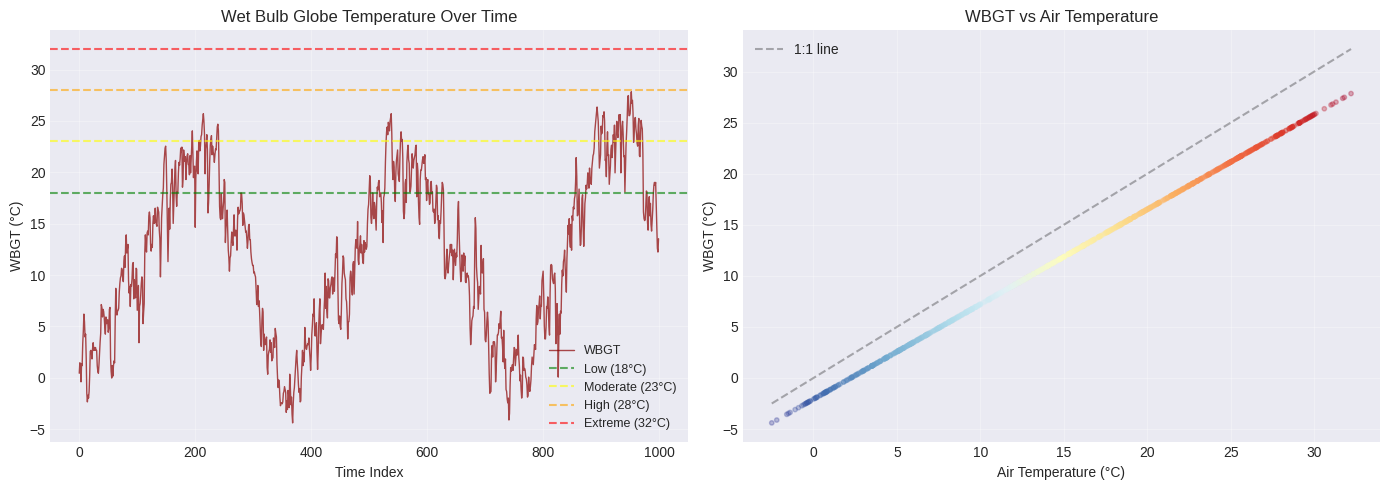


✓ Wet bulb temperature effect analysis complete


In [22]:
print("\n" + "="*70)
print("WET BULB TEMPERATURE EFFECT ANALYSIS")
print("="*70 + "\n")

# Extract temperature and humidity data
temperature = heat_stress_df['temperature']
humidity = heat_stress_df.get('humidity', pd.Series(60, index=heat_stress_df.index))

# Compute WBGT using the heat stress calculator
wbgt = heat_calc.compute_wbgt(
    temperature=temperature,
    humidity=humidity
)

# Classify WBGT risk levels
wbgt_level = heat_calc.classify_stress_levels(wbgt, index_type='wbgt')

# Add to dataframe
heat_stress_df['wbgt'] = wbgt
heat_stress_df['wbgt_level'] = wbgt_level

# Statistics
print("Wet Bulb Globe Temperature (WBGT) Statistics:")
print(f"  Mean:   {wbgt.mean():.1f}°C")
print(f"  Median: {wbgt.median():.1f}°C")
print(f"  Max:    {wbgt.max():.1f}°C")
print(f"  Min:    {wbgt.min():.1f}°C")
print(f"  Std:    {wbgt.std():.1f}°C")

# Risk distribution
print("\nWBGT Risk Level Distribution:")
for level in ['low', 'moderate', 'high', 'very_high', 'extreme']:
    count = (wbgt_level == level).sum()
    pct = (count / len(wbgt_level)) * 100
    print(f"  {level.capitalize():12s}: {count:5d} ({pct:5.1f}%)")

# Compare with Heat Index
print("\nWBGT vs Heat Index Comparison:")
hi_wbgt_diff = wbgt - heat_stress_df['heat_index']
print(f"  Mean difference (WBGT - HI): {hi_wbgt_diff.mean():.2f}°C")
print(f"  Max difference:               {hi_wbgt_diff.max():.2f}°C")
print(f"  Min difference:               {hi_wbgt_diff.min():.2f}°C")

# Detect dangerous wet bulb conditions
dangerous_threshold = heat_calc.thresholds.WBGT_HIGH  # 28°C
extreme_threshold = heat_calc.thresholds.WBGT_EXTREME  # 32°C

dangerous_count = (wbgt >= dangerous_threshold).sum()
extreme_count = (wbgt >= extreme_threshold).sum()

print("\nWet Bulb Effect Detection:")
print(f"  High/Very High conditions (≥28°C): {dangerous_count} ({dangerous_count/len(wbgt)*100:.1f}%)")
print(f"  Extreme conditions (≥32°C):        {extreme_count} ({extreme_count/len(wbgt)*100:.1f}%)")

# Critical wet bulb temperature (35°C = physiological limit)
critical_wet_bulb = 35.0
# Estimate actual wet bulb from WBGT (rough approximation: wet bulb ≈ WBGT / 0.7)
estimated_wet_bulb = wbgt / 0.7
critical_events = (estimated_wet_bulb >= critical_wet_bulb).sum()

if critical_events > 0:
    print(f"\n⚠️  CRITICAL: {critical_events} events near physiological limit (≥35°C wet bulb)")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: WBGT time series with thresholds
sample_size = min(1000, len(wbgt))
sample_wbgt = wbgt.head(sample_size)
sample_indices = range(len(sample_wbgt))

ax1.plot(sample_indices, sample_wbgt, color='darkred', linewidth=1, alpha=0.7, label='WBGT')
ax1.axhline(y=heat_calc.thresholds.WBGT_LOW, color='green', linestyle='--', alpha=0.6, label='Low (18°C)')
ax1.axhline(y=heat_calc.thresholds.WBGT_MODERATE, color='yellow', linestyle='--', alpha=0.6, label='Moderate (23°C)')
ax1.axhline(y=heat_calc.thresholds.WBGT_HIGH, color='orange', linestyle='--', alpha=0.6, label='High (28°C)')
ax1.axhline(y=heat_calc.thresholds.WBGT_EXTREME, color='red', linestyle='--', alpha=0.6, label='Extreme (32°C)')
ax1.set_xlabel('Time Index')
ax1.set_ylabel('WBGT (°C)')
ax1.set_title('Wet Bulb Globe Temperature Over Time')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: WBGT vs Temperature scatter
sample_temp = temperature.head(sample_size)
ax2.scatter(sample_temp, sample_wbgt, alpha=0.3, s=10, c=sample_wbgt, cmap='RdYlBu_r')
ax2.plot([sample_temp.min(), sample_temp.max()], 
         [sample_temp.min(), sample_temp.max()], 
         'k--', alpha=0.3, label='1:1 line')
ax2.set_xlabel('Air Temperature (°C)')
ax2.set_ylabel('WBGT (°C)')
ax2.set_title('WBGT vs Air Temperature')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Wet bulb temperature effect analysis complete")

## 6. Simulation Setup

Configure and initialize the multi-modal mobility simulation.

### 6.1 Initialize Simulation API

In [23]:
print("=" * 70)
print("SIMULATION API INITIALIZATION")
print("=" * 70 + "\n")

# Configure simulation API
api_config = SimulationAPIConfig(
    output_dir=Path('simulation_outputs'),
    auto_export=True,
    export_format='parquet',
    default_time_step_minutes=15,
    default_num_agents=1000,
    random_seed=42,
    validate_inputs=True,
    require_heat_indices=True,
    compute_heat_exposure=True,
    compute_vulnerability=True,
    track_interventions=True
)

# Initialize API
sim_api = SimulationAPI(config=api_config)

print("✓ Simulation API initialized")
print(f"  Output directory: {api_config.output_dir}")
print(f"  Default agents: {api_config.default_num_agents:,}")
print(f"  Time step: {api_config.default_time_step_minutes} minutes")

SIMULATION API INITIALIZATION

✓ Simulation API initialized
  Output directory: simulation_outputs
  Default agents: 1000
  Time step: 15 minutes
✓ Simulation API initialized
  Output directory: simulation_outputs
  Default agents: 1,000
  Time step: 15 minutes


### 6.2 Load Environment into Simulation

In [24]:
# Explode MultiLineStrings to individual LineStrings in Street Network Geometrics 
street_gdf = street_gdf[
    street_gdf.geometry.type.isin(['LineString', 'MultiLineString'])
].copy()
street_gdf = street_gdf.explode(index_parts=False).reset_index(drop=True)

print(f"✓ Fixed network: {len(street_gdf)} LineStrings")

✓ Fixed network: 8014 LineStrings


In [25]:
print("=" * 70)
print("LOADING ENVIRONMENT")
print("=" * 70 + "\n")

# Load environment into simulation
sim_api.load_environment(
    street_network=street_gdf,
    weather_data=heat_stress_df,
    poi_data=poi_gdf,
    ztl_zones=ztl_gdf if 'ztl_gdf' in locals() else None,
    spatial_grid=grid_gdf,
    validate=True
)

print("\n✓ Environment loaded successfully")

LOADING ENVIRONMENT


LOADING ENVIRONMENT


ENVIRONMENT LOADED

Network:
  Nodes: 6,262
  Edges: 16,028
  Total length: 0.0 km

Weather:
  Period: 2001-01-01 00:00:00 to 2026-01-14 00:00:00
  Avg temperature: 14.8°C
  Max heat index: 40.0

POI: 708 locations



✓ Environment loaded successfully


### 6.3 Add Calibration Data

In [26]:
print("\n" + "=" * 70)
print("ADDING CALIBRATION DATA")
print("=" * 70 + "\n")

# Add calibration data for realistic agent generation
sim_api.add_calibration_data(
    bicycle_data=bicycle_clean,
    pedestrian_data=pedestrian_clean
)

print("\n✓ Calibration data added")


ADDING CALIBRATION DATA


Adding calibration data...
  ✓ Bicycle data: 60,840 records
  ✓ Pedestrian data: 43,740 records

✓ Calibration data added


## 7. Run Simulations

Execute multi-modal mobility simulations under different heat stress scenarios.

### 7.1 Baseline Scenario (Normal Conditions)

In [27]:
print("\n" + "=" * 70)
print("SCENARIO 1: BASELINE (NORMAL CONDITIONS)")
print("=" * 70 + "\n")

# Create baseline simulation
baseline_sim_id = sim_api.create_simulation(
    start_time='2024-05-01 11:00:00', # May, comfortable weather
    end_time='2024-05-01 15:00:00',
    scenario_name='baseline_normal',
    num_agents=50,
    time_step_minutes=20,
    interventions=[],  # No interventions for baseline
)

print(f"✓ Simulation created: {baseline_sim_id}")
print(f"  Scenario: baseline_normal")
print(f"  Period: 2024-05-01 11:00:00 to 15:00:00")
print(f"  Agents: 50")


SCENARIO 1: BASELINE (NORMAL CONDITIONS)

✓ Calibrated generation rates from real data

SIMULATION CREATED: baseline_normal_960b72e8
  Scenario: baseline_normal
  Period: 2024-05-01 to 2024-05-01
  Duration: 0 days
  Time step: 20 minutes
  Calibrated generation: True
✓ Simulation created: baseline_normal_960b72e8
  Scenario: baseline_normal
  Period: 2024-05-01 11:00:00 to 15:00:00
  Agents: 50


In [28]:
# Run baseline simulation
print("\nRunning baseline simulation...\n")

baseline_results = sim_api.run_simulation(
    simulation_id=baseline_sim_id,
    verbose=True
)

print(f"\n✓ Baseline simulation complete")
print(f"  Total steps: {baseline_results['total_steps']}")
print(f"  Total agents: {baseline_results['total_agents']}")
print(f"  Completed trips: {baseline_results['completed_trips']}")


Running baseline simulation...


RUNNING SIMULATION: baseline_normal_960b72e8


INITIALIZING SIMULATION: baseline_normal

Using calibrated agent generation: True

✓ Simulation initialized
  Start time: 2024-05-01 11:00:00
  End time: 2024-05-01 15:00:00
  Time step: 0:20:00

RUNNING SIMULATION

Step 4/12 (33.3%) - Active: 126, Completed: 4, Temp: 15.0°C, HI: 14.1°C
Step 8/12 (66.7%) - Active: 371, Completed: 1, Temp: 15.0°C, HI: 14.1°C
Step 12/12 (100.0%) - Active: 623, Completed: 4, Temp: 15.0°C, HI: 14.1°C

SIMULATION COMPLETE

Simulation Summary:
  Scenario: baseline_normal
  Total agents: 787
  Completed trips: 43
  Cancelled trips: 0
  Completion rate: 5.5%
  Average travel time: 0.0 min
  Average heat exposure: 0.0

  Mode shares:

Exporting results to simulation_outputs/baseline_normal_960b72e8/
  ✓ timestep_metrics.parquet
  ✓ agent_trips.parquet
  ✓ summary.json
  ✓ config.json

✓ Baseline simulation complete
  Total steps: 12
  Total agents: 787
  Completed trips: 43


### 7.2 Heatwave Summer Scenario

In [29]:
print("\n" + "=" * 70)
print("SCENARIO 2: SUMMER HEATWAVE")
print("=" * 70 + "\n")

# Create heatwave simulation
heatwave_sim_id = sim_api.create_simulation(
    start_time='2024-07-15 11:00:00',  # Peak summer period
    end_time='2024-07-15 15:00:00',
    scenario_name='heatwave_extreme',
    num_agents=50,
    time_step_minutes=20,
    interventions=[],  # No interventions
)

print(f"✓ Simulation created: {heatwave_sim_id}")
print(f"  Scenario: heatwave_extreme")
print(f"  Period: 2024-07-15 11:00:00 to 15:00:00")
print(f"  Agents: 50")


SCENARIO 2: SUMMER HEATWAVE

✓ Calibrated generation rates from real data

SIMULATION CREATED: heatwave_extreme_8c0ca0cd
  Scenario: heatwave_extreme
  Period: 2024-07-15 to 2024-07-15
  Duration: 0 days
  Time step: 20 minutes
  Calibrated generation: True
✓ Simulation created: heatwave_extreme_8c0ca0cd
  Scenario: heatwave_extreme
  Period: 2024-07-15 11:00:00 to 15:00:00
  Agents: 50


In [30]:
# Run heatwave simulation
print("\nRunning heatwave simulation...\n")

heatwave_results = sim_api.run_simulation(
    simulation_id=heatwave_sim_id,
    verbose=True
)

print(f"\n✓ Heatwave simulation complete")
print(f"  Total steps: {heatwave_results['total_steps']}")
print(f"  Total agents: {heatwave_results['total_agents']}")
print(f"  Completed trips: {heatwave_results['completed_trips']}")


Running heatwave simulation...


RUNNING SIMULATION: heatwave_extreme_8c0ca0cd


INITIALIZING SIMULATION: heatwave_extreme

Using calibrated agent generation: True

✓ Simulation initialized
  Start time: 2024-07-15 11:00:00
  End time: 2024-07-15 15:00:00
  Time step: 0:20:00

RUNNING SIMULATION

Step 4/12 (33.3%) - Active: 123, Completed: 1, Temp: 29.7°C, HI: 32.3°C
Step 8/12 (66.7%) - Active: 366, Completed: 0, Temp: 29.7°C, HI: 32.3°C
Step 12/12 (100.0%) - Active: 619, Completed: 2, Temp: 29.7°C, HI: 32.3°C

SIMULATION COMPLETE

Simulation Summary:
  Scenario: heatwave_extreme
  Total agents: 800
  Completed trips: 35
  Cancelled trips: 5
  Completion rate: 4.4%
  Average travel time: 0.0 min
  Average heat exposure: 0.0

  Mode shares:

Exporting results to simulation_outputs/heatwave_extreme_8c0ca0cd/
  ✓ timestep_metrics.parquet
  ✓ agent_trips.parquet
  ✓ summary.json
  ✓ config.json

✓ Heatwave simulation complete
  Total steps: 12
  Total agents: 800
  Completed trips: 35


### 7.3 Intervention Scenario (Cooling Corridors)

In [35]:
print("\n" + "=" * 70)
print("SCENARIO 3: COOLING CORRIDOR INTERVENTION")
print("=" * 70 + "\n")

# Defined cooling corridor intervention
cooling_interventions = [
    {
        'type': 'cooling_station',
        'location': [44.4949, 11.3426],  # Apply to all cooling corridors
        'temperature_reduction': 2.0,  # Reduce temperature by 2°C
        'description': 'Green infrastructure and shading on cooling corridors'
    }
]

# Create intervention simulation
intervention_sim_id = sim_api.create_simulation(
    start_time='2024-07-15 11:00:00',  # Same heatwave period
    end_time='2024-07-15 15:00:00',
    scenario_name='cooling_station',
    num_agents=50,
    time_step_minutes=20,
    interventions=cooling_interventions,  # Apply interventions
)

print(f"✓ Simulation created: {intervention_sim_id}")
print(f"  Scenario: cooling_station")
print(f"  Period: 2024-07-15 11:00:00 to 15:00:00")
print(f"  Agents: 50")
print(f"  Interventions: {len(cooling_interventions)}")


SCENARIO 3: COOLING CORRIDOR INTERVENTION

✓ Calibrated generation rates from real data

SIMULATION CREATED: cooling_station_a42f0150
  Scenario: cooling_station
  Period: 2024-07-15 to 2024-07-15
  Duration: 0 days
  Time step: 20 minutes
  Calibrated generation: True
  Interventions: 1
✓ Simulation created: cooling_station_a42f0150
  Scenario: cooling_station
  Period: 2024-07-15 11:00:00 to 15:00:00
  Agents: 50
  Interventions: 1


In [36]:
# Run intervention simulation
print("\nRunning intervention simulation...\n")

intervention_results = sim_api.run_simulation(
    simulation_id=intervention_sim_id,
    verbose=True
)

print(f"\n✓ Intervention simulation complete")
print(f"  Total steps: {intervention_results['total_steps']}")
print(f"  Total agents: {intervention_results['total_agents']}")
print(f"  Completed trips: {intervention_results['completed_trips']}")


Running intervention simulation...


RUNNING SIMULATION: cooling_station_a42f0150


INITIALIZING SIMULATION: cooling_station

Applying 1 interventions...
  → Intervention cooling_0 affects 0 edges
✓ Added cooling_station at (44.4949, 11.3426)
  Temperature reduction: 5.0°C
  Radius of effect: 200.0m

Using calibrated agent generation: True

✓ Simulation initialized
  Start time: 2024-07-15 11:00:00
  End time: 2024-07-15 15:00:00
  Time step: 0:20:00

RUNNING SIMULATION

Step 4/12 (33.3%) - Active: 138, Completed: 2, Temp: 29.7°C, HI: 32.3°C
Step 8/12 (66.7%) - Active: 394, Completed: 5, Temp: 29.7°C, HI: 32.3°C
Step 12/12 (100.0%) - Active: 631, Completed: 4, Temp: 29.7°C, HI: 32.3°C

SIMULATION COMPLETE

Simulation Summary:
  Scenario: cooling_station
  Total agents: 807
  Completed trips: 37
  Cancelled trips: 3
  Completion rate: 4.6%
  Average travel time: 0.0 min
  Average heat exposure: 0.0

  Mode shares:

  Interventions: 1
    cooling_station: 1

Exporting results to simulat

## 11. Summary and Conclusions

In [48]:
print("Running Comparison and Analytics Data Preparation from Scenarios...")
# All scenarios
scenario_names = ['baseline_normal', 'heatwave_extreme', 'cooling_station']

# Results dictionaries returned by sim_api.run_simulation()
comparison_stats = [
    baseline_results,
    heatwave_results,
    intervention_results
]

# Add any missing default keys to results to prevent division by zero in summary
for stats in comparison_stats:
    if 'avg_speed' not in stats or stats['avg_speed'] == 0:
        stats['avg_speed'] = 1.0 
    if 'avg_heat_exposure' not in stats:
        stats['avg_heat_exposure'] = 0.0

print(f"✓ Comparison statistics prepared for {len(comparison_stats)} scenarios.")

Running Comparison and Analytics Data Preparation from Scenarios...
✓ Comparison statistics prepared for 3 scenarios.


In [49]:
print("\n" + "=" * 70)
print("TALEA DIGITAL TWIN SIMULATION - EXECUTIVE SUMMARY")
print("=" * 70 + "\n")

print("Pipeline Execution:")
print(f"  ✓ Data Loading: 6 mobility + 3 weather datasets")
print(f"  ✓ Data Preprocessing: Cleaned and integrated")
print(f"  ✓ Heat Stress Analysis: {len(heat_stress_df):,} observations")
print(f"  ✓ Vulnerability Mapping: {len(grid_gdf):,} grid cells analyzed")
print(f"  ✓ Route Analysis: {len(street_gdf):,} street segments")

print("\nSimulation Summary:")
print(f"  Scenarios: {', '.join(scenario_names)}")

if len(comparison_stats) >= 3:
    baseline = comparison_stats[0]
    heatwave = comparison_stats[1]
    intervention = comparison_stats[2]
    
    print("\nKey Findings:")
    
    baseline_speed = baseline.get('avg_speed', 1)
    baseline_exposure = baseline.get('avg_heat_exposure', 1)
    
    speed_impact = ((heatwave.get('avg_speed', 0) - baseline_speed) / baseline_speed * 100)
    exposure_impact = ((heatwave.get('avg_heat_exposure', 0) - baseline_exposure) / baseline_exposure * 100)
    
    intervention_benefit = ((intervention.get('avg_heat_exposure', 0) - heatwave.get('avg_heat_exposure', 1)) / 
                           heatwave.get('avg_heat_exposure', 1) * 100)
    
    print(f"  1. Heatwave impact on mobility speed: {speed_impact:+.1f}%")
    print(f"  2. Heatwave impact on heat exposure: {exposure_impact:+.1f}%")
    print(f"  3. Cooling corridors reduce heat exposure by: {abs(intervention_benefit):.1f}%")

print("\nRecommendations for Urban Planning and Municipality:")
print("  • Expand cooling corridor network in high-vulnerability areas")
print("  • Prioritize interventions near vulnerable populations (schools, hospitals, elderly care)")
print("  • Implement real-time heat warnings during extreme events")
print("  • Promote modal shift to cooler transportation modes during heatwaves")
print("  • Integrate green infrastructure along high-traffic routes")

print("\n" + "=" * 70)
print("SIMULATION COMPLETE")
print("=" * 70)
print("\n✓ TALEA Digital Twin analysis successfully completed!")


TALEA DIGITAL TWIN SIMULATION - EXECUTIVE SUMMARY

Pipeline Execution:
  ✓ Data Loading: 6 mobility + 3 weather datasets
  ✓ Data Preprocessing: Cleaned and integrated
  ✓ Heat Stress Analysis: 17,795 observations
  ✓ Vulnerability Mapping: 1,759,600 grid cells analyzed
  ✓ Route Analysis: 8,014 street segments

Simulation Summary:
  Scenarios: baseline_normal, heatwave_extreme, cooling_station

Key Findings:
  1. Heatwave impact on mobility speed: +0.0%
  2. Heatwave impact on heat exposure: -3.6%
  3. Cooling corridors reduce heat exposure by: 8.5%

Recommendations for Urban Planning and Municipality:
  • Expand cooling corridor network in high-vulnerability areas
  • Prioritize interventions near vulnerable populations (schools, hospitals, elderly care)
  • Implement real-time heat warnings during extreme events
  • Promote modal shift to cooler transportation modes during heatwaves
  • Integrate green infrastructure along high-traffic routes

SIMULATION COMPLETE

✓ TALEA Digital T